# Training a neural network with McSnow output

This script applies a DNN to a regression problem 

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


In [1]:
version  = '10'

### Load Tensorflow and other useful modules

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [3]:
tf.random.set_seed(1234)

### Load data from netcdf

In [4]:
import numpy as np
import xarray as xr

In [5]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

data="rimedsnow"

fname1=mdir+edir+'icebox_train_rc_'+data+'.nc'

ds1 = xr.open_dataset(fname1)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:                        (cell: 2150090)
Dimensions without coordinates: cell
Data variables: (12/204)
    time                           (cell) float32 ...
    q_cloud                        (cell) float32 ...
    n_cloud                        (cell) float32 ...
    q_rain                         (cell) float32 ...
    n_rain                         (cell) float32 ...
    q_ice                          (cell) float32 ...
    ...                             ...
    frze_graupel_rain_mass         (cell) float32 ...
    frze_graupel_rain_rmass        (cell) float32 ...
    frze_graupel_rain_rvol         (cell) float32 ...
    frze_graupel_rain_liq          (cell) float32 ...
    rime_graupel_rain_num          (cell) float32 ...
    rime_graupel_rain_mass         (cell) float32 ...
Attributes:
    title:    McSnow ice microphysics box model output pre-processed by NCL
    date:     Mo 30 Mai 2022 17:34:22 CEST
    nfiles:   10013


# Prepare data for training

In [6]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    temp = xr.open_dataset(fname).temp.values
    rho  = xr.open_dataset(fname).rho.values
    q_s  = xr.open_dataset(fname).q_rimedsnow.values
    n_s  = xr.open_dataset(fname).n_rimedsnow.values
    r_s  = xr.open_dataset(fname).rime_rimedsnow.values
    v_s  = xr.open_dataset(fname).rvol_rimedsnow.values
    liq  = xr.open_dataset(fname).liq_rimedsnow.values
    cwc  = xr.open_dataset(fname).cwc.values
    r_c  = xr.open_dataset(fname).rc.values    
    # process rates
    rate = xr.open_dataset(fname).conv_rimedsnow_cloud_num.values
    # some numerical lower bounds
    q_min = 1e-12
    n_min = 1e-12
    z_min = 1e-20
    p_min = 1.0
    conv  = np.where(rate > p_min,1,0)
    # take out cwc = 0
    conv  = np.where(cwc > 1e-6, conv, np.nan*conv)  
    # use liquid water fraction (no log transform for this)
    liq = np.where(q_s>q_min,liq/q_s,np.nan)      
    # log transforms
    n_s = np.log(n_s, where=n_s>n_min, out=np.nan*n_s)
    r_s = np.log(r_s, where=r_s>q_min, out=np.nan*q_s)
    v_s = np.log(v_s, where=v_s>q_min, out=np.nan*q_s)
    q_s = np.log(q_s, where=q_s>q_min, out=np.nan*q_s)
    cwc = np.log(cwc, where=cwc>q_min, out=np.nan*q_s)    
    r_c = np.log(r_c, where=r_c>q_min, out=np.nan*q_s)
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [ q_s, n_s, r_s, v_s, liq, cwc, r_c, temp, rho, conv ]))
    dataset = dataset.T
    dataset.columns = [ 'q_s', 'n_s', 'r_s', 'v_s', 'liq', 'cwc', 'rc', 'temp', 'rho', 'conv' ] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [7]:
df = read_and_prepare_data(fname1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater


In [8]:
df.describe()

q_s            n_s            r_s            v_s  \
count  262365.000000  262365.000000  262365.000000  262365.000000   
mean       -5.911188       4.063810      -6.870205     -12.839383   
std         1.937739       4.715286       2.285636       2.115763   
min       -22.376656     -14.498609     -22.616461     -27.630621   
25%        -6.506767       1.733371      -7.651459     -13.337353   
50%        -5.547086       4.881134      -6.536674     -12.419439   
75%        -4.819639       7.537057      -5.462508     -11.663865   
max        -3.408736      14.175838      -3.589831      -8.804675   

                 liq            cwc             rc           temp  \
count  262365.000000  262365.000000  262365.000000  262365.000000   
mean        0.035991     -10.051211     -11.020026     266.547468   
std         0.082735       2.115064       0.491542       5.962682   
min         0.000000     -13.805560     -12.203955     245.550003   
25%         0.000006     -11.780805     -11.356195     263.989990   
50%         0.001581     -10.101938     -10.977848     268.049988   
75%         0.028000      -8.390560     -10.601117     271.160004   
max         0.995772      -3.780995     -10.260165     275.140015   

                 rho           conv  
count  262365.000000  262365.000000  
mean        1.030378       0.039765  
std         0.101556       0.195407  
min         0.711000       0.000000  
25%         0.973000       0.000000  
50%         1.047000       0.000000  
75%         1.104000       0.000000  
max         1.286000       1.000000

### Split in training, testing and validation with 70/15/15 rule

In [9]:
msk = np.random.rand(len(df)) < 0.7
dataset_train = df[msk]

df2 = df[~msk]
msk = np.random.rand(len(df2)) < 0.5

dataset_test = df2[msk]
dataset_val = df2[~msk]

### Inspect the data

In [10]:
dataset_train.head()

q_s       n_s        r_s        v_s           liq       cwc  \
0 -8.190158  8.328547 -12.067076 -17.079985  4.633522e-08 -8.772085   
1 -8.145182  8.327775 -10.987842 -16.001913  0.000000e+00 -8.859683   
2 -8.104156  8.323147 -10.500016 -15.516023  5.198491e-06 -8.947976   
3 -8.066754  8.318206 -10.189570 -15.207219  0.000000e+00 -9.044826   
4 -8.032917  8.313460  -9.967386 -14.986661  0.000000e+00 -9.142682   

          rc        temp    rho  conv  
0 -12.155304  265.890015  1.038   0.0  
1 -12.155304  265.950012  1.039   0.0  
2 -12.155304  266.019989  1.040   0.0  
3 -12.155304  266.079987  1.041   0.0  
4 -12.155304  266.140015  1.042   0.0

In [11]:
dataset_train.describe()

q_s            n_s            r_s            v_s  \
count  183380.000000  183380.000000  183380.000000  183380.000000   
mean       -5.913620       4.065137      -6.873557     -12.841959   
std         1.941084       4.713153       2.287951       2.118609   
min       -22.376656     -14.498609     -22.616461     -27.630522   
25%        -6.507437       1.734867      -7.654335     -13.338965   
50%        -5.546855       4.881361      -6.539231     -12.419489   
75%        -4.820764       7.539080      -5.465264     -11.665200   
max        -3.408736      14.175838      -3.589831      -8.804675   

                 liq            cwc             rc           temp  \
count  183380.000000  183380.000000  183380.000000  183380.000000   
mean        0.036153     -10.051491     -11.020558     266.538182   
std         0.083372       2.114836       0.491597       5.967481   
min         0.000000     -13.805560     -12.203955     245.550003   
25%         0.000005     -11.779499     -11.356931     263.989990   
50%         0.001562     -10.101938     -10.977995     268.040009   
75%         0.027947      -8.390560     -10.601117     271.160004   
max         0.995772      -3.780995     -10.260165     275.140015   

                 rho           conv  
count  183380.000000  183380.000000  
mean        1.030207       0.039644  
std         0.101563       0.195123  
min         0.712000       0.000000  
25%         0.973000       0.000000  
50%         1.046000       0.000000  
75%         1.103000       0.000000  
max         1.286000       1.000000

In [12]:
dataset_test.describe()

q_s           n_s           r_s           v_s           liq  \
count  39356.000000  39356.000000  39356.000000  39356.000000  39356.000000   
mean      -5.904706      4.057341     -6.866769    -12.838785      0.035842   
std        1.931057      4.696210      2.277723      2.108086      0.081636   
min      -22.282820    -14.357827    -22.435789    -27.627428      0.000000   
25%       -6.500575      1.699786     -7.641376    -13.334150      0.000006   
50%       -5.548370      4.873211     -6.535675    -12.425112      0.001622   
75%       -4.819565      7.510704     -5.461272    -11.665456      0.028218   
max       -3.429844     14.035609     -3.597650     -8.927796      0.989890   

                cwc            rc          temp           rho          conv  
count  39356.000000  39356.000000  39356.000000  39356.000000  39356.000000  
mean     -10.046061    -11.014568    266.581960      1.030903      0.040502  
std        2.110379      0.491906      5.950830      0.101230      0.197136  
min      -13.805560    -12.203955    245.600006      0.713000      0.000000  
25%      -11.762670    -11.346030    264.010010      0.973000      0.000000  
50%      -10.100720    -10.970496    268.089996      1.047000      0.000000  
75%       -8.381788    -10.597816    271.190002      1.104000      0.000000  
max       -3.947650    -10.260165    274.429993      1.286000      1.000000

In [13]:
dataset_val.describe()

q_s           n_s           r_s           v_s           liq  \
count  39629.000000  39629.000000  39629.000000  39629.000000  39629.000000   
mean      -5.906374      4.064093     -6.858107    -12.828054      0.035390   
std        1.928875      4.744086      2.282773      2.110204      0.080838   
min      -22.165453    -14.498609    -22.439732    -27.630621      0.000000   
25%       -6.508576      1.760957     -7.648225    -13.332221      0.000006   
50%       -5.547061      4.886809     -6.525695    -12.415215      0.001619   
75%       -4.814892      7.554073     -5.451305    -11.655342      0.028072   
max       -3.453554     14.167435     -3.594879     -9.033366      0.992788   

                cwc            rc          temp           rho          conv  
count  39629.000000  39629.000000  39629.000000  39629.000000  39629.000000  
mean     -10.055025    -11.022982    266.556181      1.030644      0.039592  
std        2.120800      0.490900      5.952223      0.101847      0.195002  
min      -13.805560    -12.203955    245.619995      0.711000      0.000000  
25%      -11.796616    -11.356931    264.000000      0.973000      0.000000  
50%      -10.106829    -10.984971    268.059998      1.047000      0.000000  
75%       -8.373093    -10.605413    271.179993      1.104000      0.000000  
max       -3.868006    -10.260165    273.489990      1.284000      1.000000

### Further reduce data to relevant parameter range

In [14]:
def reduce_data(dataset):
    idx = dataset[ dataset['q_s'] < -20 ].index
    dataset.drop(idx,inplace=True)   
    idx = dataset[ dataset['temp'] > 273 ].index
    dataset.drop(idx,inplace=True)   
    return dataset

In [15]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)
dataset_val   = reduce_data(dataset_val)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
dataset_train.describe()

q_s            n_s            r_s            v_s  \
count  172019.000000  172019.000000  172019.000000  172019.000000   
mean       -5.912651       4.229041      -6.873757     -12.827124   
std         1.836403       4.604577       2.208095       2.028256   
min       -19.996828     -14.498609     -22.616461     -27.627129   
25%        -6.536468       1.984746      -7.686155     -13.350771   
50%        -5.580760       4.936199      -6.565798     -12.427518   
75%        -4.832309       7.629441      -5.476464     -11.673493   
max        -3.408736      14.175838      -3.589831      -8.804675   

                 liq            cwc             rc           temp  \
count  172019.000000  172019.000000  172019.000000  172019.000000   
mean        0.033160      -9.984060     -11.018272     266.115835   
std         0.080402       2.090737       0.492282       5.918564   
min         0.000000     -13.805560     -12.203955     245.550003   
25%         0.000003     -11.677800     -11.356195     263.609985   
50%         0.001145     -10.024526     -10.971346     267.640015   
75%         0.021936      -8.355925     -10.599122     270.640015   
max         0.995572      -3.780995     -10.260165     273.000000   

                 rho           conv  
count  172019.000000  172019.000000  
mean        1.023330       0.042205  
std         0.100319       0.201056  
min         0.712000       0.000000  
25%         0.967000       0.000000  
50%         1.040000       0.000000  
75%         1.096000       0.000000  
max         1.285000       1.000000

In [17]:
dataset_test.describe()

q_s           n_s           r_s           v_s           liq  \
count  36856.000000  36856.000000  36856.000000  36856.000000  36856.000000   
mean      -5.892567      4.211970     -6.858586    -12.814624      0.032742   
std        1.799466      4.591504      2.178887      1.995379      0.078971   
min      -19.984619    -14.357827    -22.435789    -27.447367      0.000000   
25%       -6.524945      1.942755     -7.673011    -13.342636      0.000004   
50%       -5.580084      4.917862     -6.559037    -12.431381      0.001159   
75%       -4.827508      7.588096     -5.470607    -11.668399      0.022012   
max       -3.429844     14.035609     -3.597650     -8.927796      0.980080   

                cwc            rc          temp           rho          conv  
count  36856.000000  36856.000000  36856.000000  36856.000000  36856.000000  
mean      -9.978518    -11.012442    266.152109      1.023899      0.043168  
std        2.087694      0.492661      5.902947      0.099999      0.203238  
min      -13.805560    -12.203955    245.600006      0.713000      0.000000  
25%      -11.666077    -11.344703    263.617493      0.967000      0.000000  
50%      -10.030186    -10.966731    267.670013      1.040000      0.000000  
75%       -8.343240    -10.593428    270.670013      1.096000      0.000000  
max       -3.947650    -10.260165    273.000000      1.279000      1.000000

### Pairplot

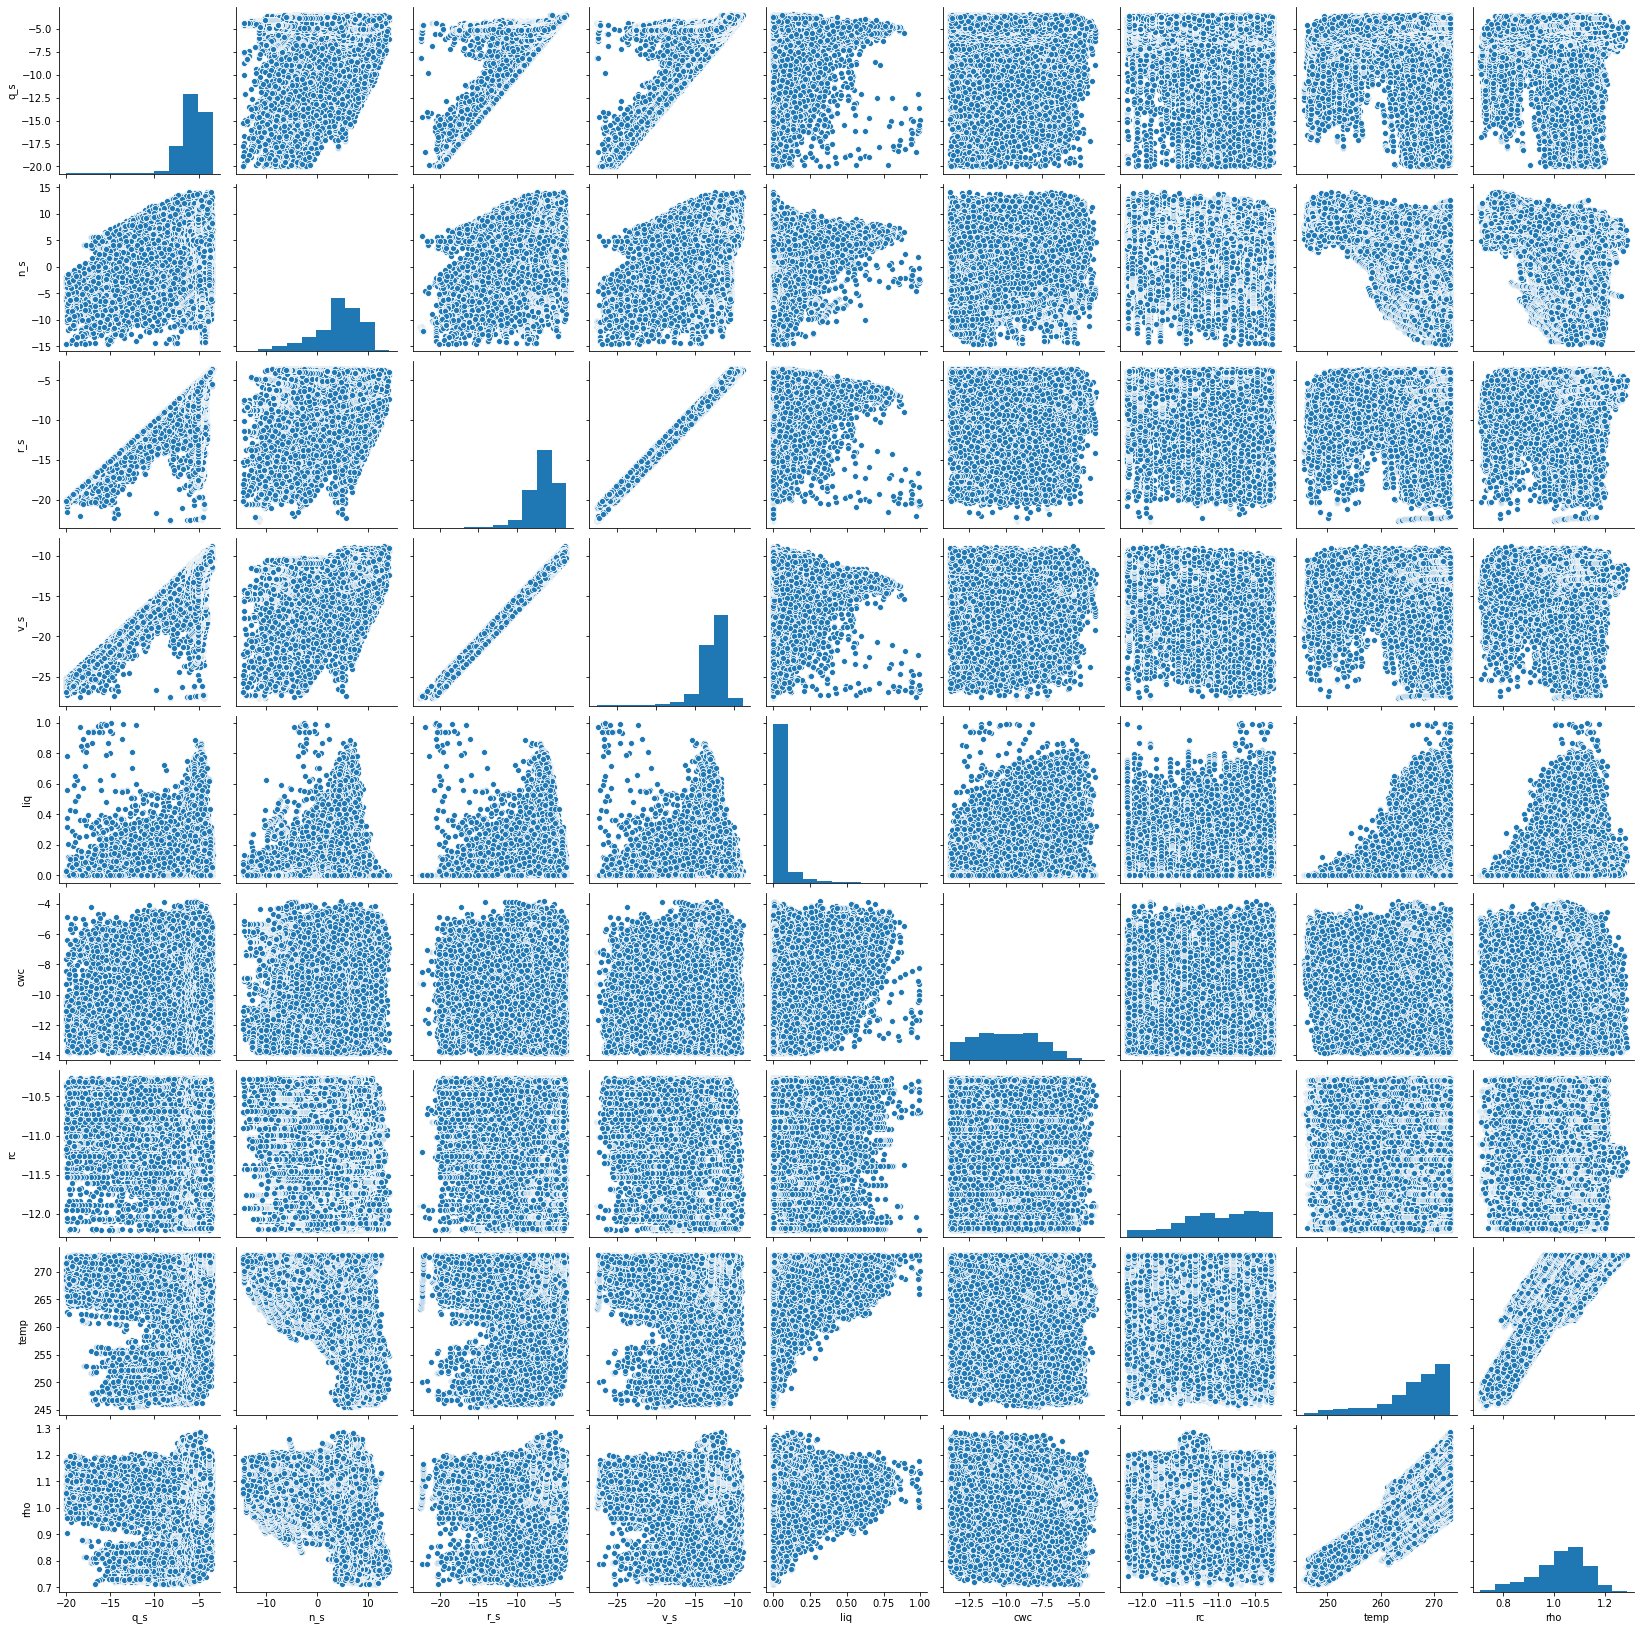

In [18]:
sns.pairplot(dataset_train[["q_s","n_s","r_s","v_s","liq","cwc","rc","temp","rho"]], diag_kind="hist")

## Separate in different dataset with selected sets of predictors

In [19]:
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()

In [20]:
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()

In [21]:
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()

In [22]:
train_dataset1 = train_dataset1.drop(['temp','rho','liq'], axis=1)
train_dataset2 = train_dataset2.drop(['temp','rho'], axis=1)
#train_dataset3 = train_dataset3.drop(['rho'], axis=1)

In [23]:
test_dataset1 = test_dataset1.drop(['temp','rho','liq'], axis=1)
test_dataset2 = test_dataset2.drop(['temp','rho'], axis=1)
#test_dataset3 = test_dataset3.drop(['rho'], axis=1)

In [24]:
val_dataset1 = val_dataset1.drop(['temp','rho','liq'], axis=1)
val_dataset2 = val_dataset2.drop(['temp','rho'], axis=1)
#val_dataset3 = val_dataset3.drop(['rho'], axis=1)

In [25]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("conv")
train_stats1 = train_stats1.transpose()
train_stats1

count       mean       std        min        25%        50%  \
q_s  172019.0  -5.912651  1.836403 -19.996828  -6.536468  -5.580760   
n_s  172019.0   4.229041  4.604577 -14.498609   1.984746   4.936199   
r_s  172019.0  -6.873757  2.208095 -22.616461  -7.686155  -6.565798   
v_s  172019.0 -12.827124  2.028256 -27.627129 -13.350771 -12.427518   
cwc  172019.0  -9.984060  2.090737 -13.805560 -11.677800 -10.024526   
rc   172019.0 -11.018272  0.492282 -12.203955 -11.356195 -10.971346   

           75%        max  
q_s  -4.832309  -3.408736  
n_s   7.629441  14.175838  
r_s  -5.476464  -3.589831  
v_s -11.673493  -8.804675  
cwc  -8.355925  -3.780995  
rc  -10.599122 -10.260165

In [26]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("conv")
train_stats2 = train_stats2.transpose()
train_stats2

count       mean       std        min        25%        50%  \
q_s  172019.0  -5.912651  1.836403 -19.996828  -6.536468  -5.580760   
n_s  172019.0   4.229041  4.604577 -14.498609   1.984746   4.936199   
r_s  172019.0  -6.873757  2.208095 -22.616461  -7.686155  -6.565798   
v_s  172019.0 -12.827124  2.028256 -27.627129 -13.350771 -12.427518   
liq  172019.0   0.033160  0.080402   0.000000   0.000003   0.001145   
cwc  172019.0  -9.984060  2.090737 -13.805560 -11.677800 -10.024526   
rc   172019.0 -11.018272  0.492282 -12.203955 -11.356195 -10.971346   

           75%        max  
q_s  -4.832309  -3.408736  
n_s   7.629441  14.175838  
r_s  -5.476464  -3.589831  
v_s -11.673493  -8.804675  
liq   0.021936   0.995572  
cwc  -8.355925  -3.780995  
rc  -10.599122 -10.260165

In [27]:
train_stats3 = train_dataset3.describe()
train_stats3.pop("conv")
train_stats3 = train_stats3.transpose()
train_stats3

count        mean       std         min         25%         50%  \
q_s   172019.0   -5.912651  1.836403  -19.996828   -6.536468   -5.580760   
n_s   172019.0    4.229041  4.604577  -14.498609    1.984746    4.936199   
r_s   172019.0   -6.873757  2.208095  -22.616461   -7.686155   -6.565798   
v_s   172019.0  -12.827124  2.028256  -27.627129  -13.350771  -12.427518   
liq   172019.0    0.033160  0.080402    0.000000    0.000003    0.001145   
cwc   172019.0   -9.984060  2.090737  -13.805560  -11.677800  -10.024526   
rc    172019.0  -11.018272  0.492282  -12.203955  -11.356195  -10.971346   
temp  172019.0  266.115835  5.918564  245.550003  263.609985  267.640015   
rho   172019.0    1.023330  0.100319    0.712000    0.967000    1.040000   

             75%         max  
q_s    -4.832309   -3.408736  
n_s     7.629441   14.175838  
r_s    -5.476464   -3.589831  
v_s   -11.673493   -8.804675  
liq     0.021936    0.995572  
cwc    -8.355925   -3.780995  
rc    -10.599122  -10.260165  
temp  270.640015  273.000000  
rho     1.096000    1.285000

### Split features from labels (here we need only one set of labels)

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [28]:
# pop does not work for multiple columns, use copy instead

labels = ['conv']

train_labels = train_dataset1[labels].copy()
train_dataset1.drop(labels, axis=1, inplace=True)

test_labels = test_dataset1[labels].copy()
test_dataset1.drop(labels, axis=1, inplace=True)

val_labels = val_dataset1[labels].copy()
val_dataset1.drop(labels, axis=1, inplace=True)

In [29]:
train_dataset2.drop(labels, axis=1, inplace=True)
test_dataset2.drop(labels, axis=1, inplace=True)
val_dataset2.drop(labels, axis=1, inplace=True)

In [30]:
train_dataset3.drop(labels, axis=1, inplace=True)
test_dataset3.drop(labels, axis=1, inplace=True)
val_dataset3.drop(labels, axis=1, inplace=True)

In [31]:
train_labels.describe()

conv
count  172019.000000
mean        0.042205
std         0.201056
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000

In [32]:
train_dataset1.describe()

q_s            n_s            r_s            v_s  \
count  172019.000000  172019.000000  172019.000000  172019.000000   
mean       -5.912651       4.229041      -6.873757     -12.827124   
std         1.836403       4.604577       2.208095       2.028256   
min       -19.996828     -14.498609     -22.616461     -27.627129   
25%        -6.536468       1.984746      -7.686155     -13.350771   
50%        -5.580760       4.936199      -6.565798     -12.427518   
75%        -4.832309       7.629441      -5.476464     -11.673493   
max        -3.408736      14.175838      -3.589831      -8.804675   

                 cwc             rc  
count  172019.000000  172019.000000  
mean       -9.984060     -11.018272  
std         2.090737       0.492282  
min       -13.805560     -12.203955  
25%       -11.677800     -11.356195  
50%       -10.024526     -10.971346  
75%        -8.355925     -10.599122  
max        -3.780995     -10.260165

In [33]:
train_dataset2.describe()

q_s            n_s            r_s            v_s  \
count  172019.000000  172019.000000  172019.000000  172019.000000   
mean       -5.912651       4.229041      -6.873757     -12.827124   
std         1.836403       4.604577       2.208095       2.028256   
min       -19.996828     -14.498609     -22.616461     -27.627129   
25%        -6.536468       1.984746      -7.686155     -13.350771   
50%        -5.580760       4.936199      -6.565798     -12.427518   
75%        -4.832309       7.629441      -5.476464     -11.673493   
max        -3.408736      14.175838      -3.589831      -8.804675   

                 liq            cwc             rc  
count  172019.000000  172019.000000  172019.000000  
mean        0.033160      -9.984060     -11.018272  
std         0.080402       2.090737       0.492282  
min         0.000000     -13.805560     -12.203955  
25%         0.000003     -11.677800     -11.356195  
50%         0.001145     -10.024526     -10.971346  
75%         0.021936      -8.355925     -10.599122  
max         0.995572      -3.780995     -10.260165

In [34]:
train_dataset3.describe()

q_s            n_s            r_s            v_s  \
count  172019.000000  172019.000000  172019.000000  172019.000000   
mean       -5.912651       4.229041      -6.873757     -12.827124   
std         1.836403       4.604577       2.208095       2.028256   
min       -19.996828     -14.498609     -22.616461     -27.627129   
25%        -6.536468       1.984746      -7.686155     -13.350771   
50%        -5.580760       4.936199      -6.565798     -12.427518   
75%        -4.832309       7.629441      -5.476464     -11.673493   
max        -3.408736      14.175838      -3.589831      -8.804675   

                 liq            cwc             rc           temp  \
count  172019.000000  172019.000000  172019.000000  172019.000000   
mean        0.033160      -9.984060     -11.018272     266.115835   
std         0.080402       2.090737       0.492282       5.918564   
min         0.000000     -13.805560     -12.203955     245.550003   
25%         0.000003     -11.677800     -11.356195     263.609985   
50%         0.001145     -10.024526     -10.971346     267.640015   
75%         0.021936      -8.355925     -10.599122     270.640015   
max         0.995572      -3.780995     -10.260165     273.000000   

                 rho  
count  172019.000000  
mean        1.023330  
std         0.100319  
min         0.712000  
25%         0.967000  
50%         1.040000  
75%         1.096000  
max         1.285000

### Normalize the features

In [35]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)
normed_train_data3 = norm(train_dataset3,train_stats3)

normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)
normed_test_data3 = norm(test_dataset3,train_stats3)

normed_val_data1 = norm(val_dataset1,train_stats1)
normed_val_data2 = norm(val_dataset2,train_stats2)
normed_val_data3 = norm(val_dataset3,train_stats3)

In [36]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count          mean  std       min       25%       50%       75%  \
q_s  172019.0  3.172306e-17  1.0 -7.669437 -0.339695  0.180729  0.588293   
n_s  172019.0  9.913455e-17  1.0 -4.067181 -0.487405  0.153577  0.738483   
r_s  172019.0  1.797640e-16  1.0 -7.129541 -0.367918  0.139468  0.632805   
v_s  172019.0  5.815893e-17  1.0 -7.296913 -0.258176  0.197020  0.568780   
cwc  172019.0  2.339575e-16  1.0 -1.827825 -0.810117 -0.019355  0.778738   
rc   172019.0 -7.349174e-16  1.0 -2.408543 -0.686443  0.095323  0.851442   

          max  
q_s  1.363489  
n_s  2.160198  
r_s  1.487221  
v_s  1.983206  
cwc  2.966928  
rc   1.539984

In [37]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count          mean  std       min       25%       50%       75%  \
q_s  172019.0  3.172306e-17  1.0 -7.669437 -0.339695  0.180729  0.588293   
n_s  172019.0  9.913455e-17  1.0 -4.067181 -0.487405  0.153577  0.738483   
r_s  172019.0  1.797640e-16  1.0 -7.129541 -0.367918  0.139468  0.632805   
v_s  172019.0  5.815893e-17  1.0 -7.296913 -0.258176  0.197020  0.568780   
liq  172019.0 -4.626279e-17  1.0 -0.412430 -0.412390 -0.398189 -0.139596   
cwc  172019.0  2.339575e-16  1.0 -1.827825 -0.810117 -0.019355  0.778738   
rc   172019.0 -7.349174e-16  1.0 -2.408543 -0.686443  0.095323  0.851442   

           max  
q_s   1.363489  
n_s   2.160198  
r_s   1.487221  
v_s   1.983206  
liq  11.969990  
cwc   2.966928  
rc    1.539984

In [38]:
normed_train_stats3 = normed_train_data3.describe()
normed_train_stats3 = normed_train_stats3.transpose()
normed_train_stats3

count          mean  std       min       25%       50%       75%  \
q_s   172019.0  3.172306e-17  1.0 -7.669437 -0.339695  0.180729  0.588293   
n_s   172019.0  9.913455e-17  1.0 -4.067181 -0.487405  0.153577  0.738483   
r_s   172019.0  1.797640e-16  1.0 -7.129541 -0.367918  0.139468  0.632805   
v_s   172019.0  5.815893e-17  1.0 -7.296913 -0.258176  0.197020  0.568780   
liq   172019.0 -4.626279e-17  1.0 -0.412430 -0.412390 -0.398189 -0.139596   
cwc   172019.0  2.339575e-16  1.0 -1.827825 -0.810117 -0.019355  0.778738   
rc    172019.0 -7.349174e-16  1.0 -2.408543 -0.686443  0.095323  0.851442   
temp  172019.0 -3.116790e-15  1.0 -3.474801 -0.423388  0.257525  0.764405   
rho   172019.0 -9.516917e-17  1.0 -3.103404 -0.561513  0.166165  0.724384   

            max  
q_s    1.363489  
n_s    2.160198  
r_s    1.487221  
v_s    1.983206  
liq   11.969990  
cwc    2.966928  
rc     1.539984  
temp   1.163148  
rho    2.608374

# The model

## Build the model

In [39]:

def build_model_relu(ncol,nsize):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu'),
    layers.Dense(nsize, activation='relu'),
    layers.Dense(nsize, activation='relu'),
    layers.Dense(2)
  ])
  model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  return model

def build_model(ncol,nsize,activation):
    if activation == "sigm":
        model = build_model_sigm(ncol,nsize)
    elif activation == "ReLU":
        model = build_model_relu(ncol,nsize)
    else:
        print("Error: Wrong choice for activation")
    return model  

In [40]:
activ = "ReLU"
model = build_model(6,16,activ)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                112       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 34        
Total params: 962
Trainable params: 962
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [42]:
example_batch  = normed_train_data1[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.1421563 ,  0.17625478],
       [ 0.03559317,  0.13261706],
       [ 0.00169194,  0.10413592],
       [-0.00391837,  0.08059616],
       [-0.00914434,  0.06366795],
       [-0.02270513,  0.05390262],
       [-0.02859779,  0.05472745],
       [-0.03052169,  0.05510128],
       [-0.03329594,  0.05584115],
       [-0.03514998,  0.05627317]], dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [43]:
# maximum number, but we use early stopping
EPOCHS = 300

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=20)

# width of neural net
nsize = 16

# for collecting the histories
histories = {}

# make plots bigger than standard layout
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

In [44]:
activ = "ReLU"
model1 = build_model(len(normed_train_data1.keys()),nsize,activ)

early_history1 = model1.fit(normed_train_data1, train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, accuracy:0.9738,  loss:0.0692,  val_accuracy:0.9791,  val_loss:0.0502,  
.......................................................................

Text(0, 0.5, 'accuracy')

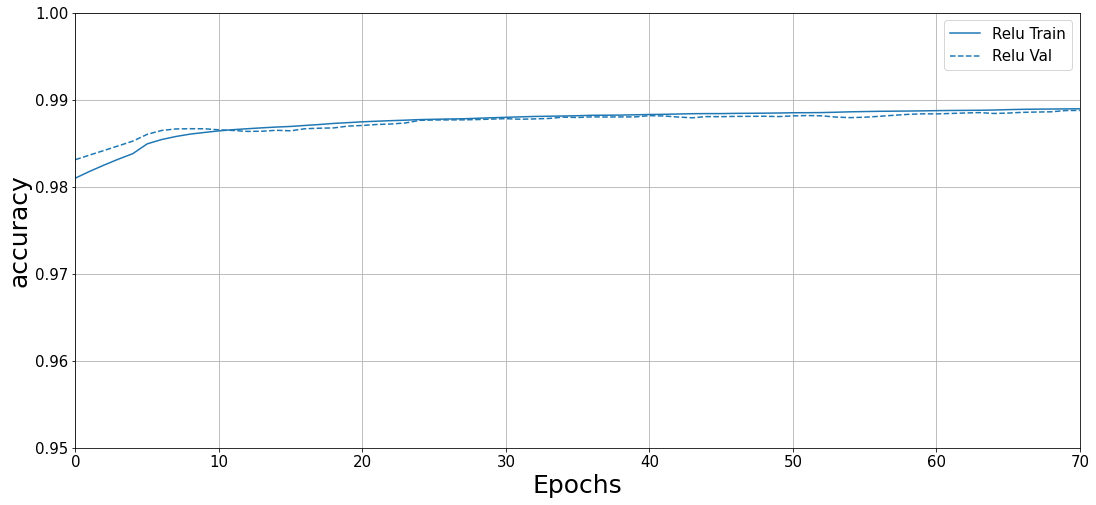

In [45]:
histories['ReLU'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = 'accuracy')
plt.ylim([0.95, 1.])
plt.ylabel('accuracy')

In [46]:
model2 = build_model(len(normed_train_data2.keys()),nsize,activ)

early_history2 = model2.fit(normed_train_data2, train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, accuracy:0.9742,  loss:0.0702,  val_accuracy:0.9792,  val_loss:0.0521,  
.................................................................................................

Text(0, 0.5, 'accuracy')

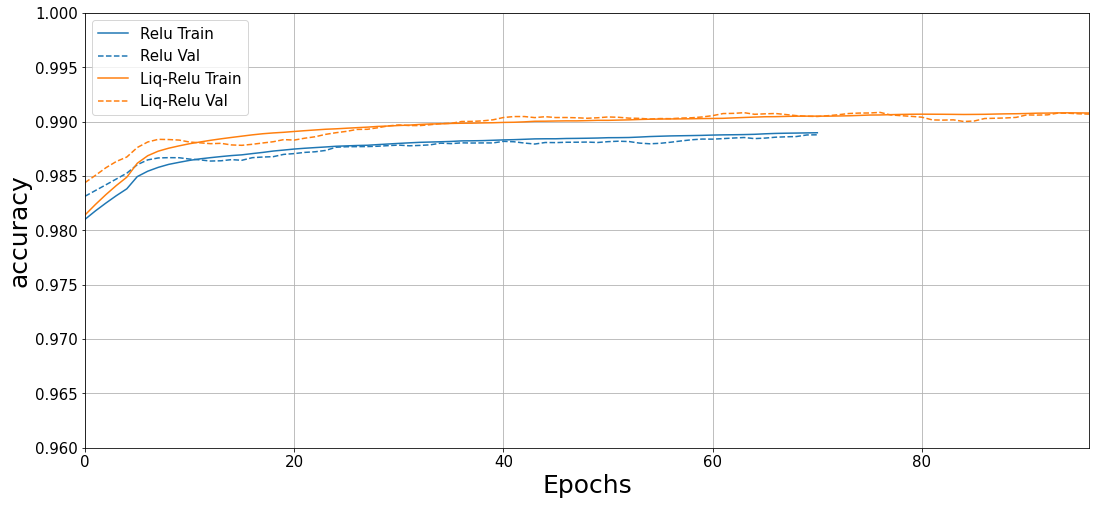

In [47]:
histories['liq-ReLU'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "accuracy")
plt.ylim([0.96, 1.0])
plt.ylabel('accuracy')

In [48]:
model3 = build_model(len(normed_train_data3.keys()),nsize,activ)

early_history3 = model3.fit(normed_train_data3, train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, accuracy:0.9753,  loss:0.0661,  val_accuracy:0.9827,  val_loss:0.0460,  
..............................................................................

Text(0, 0.5, 'accuracy')

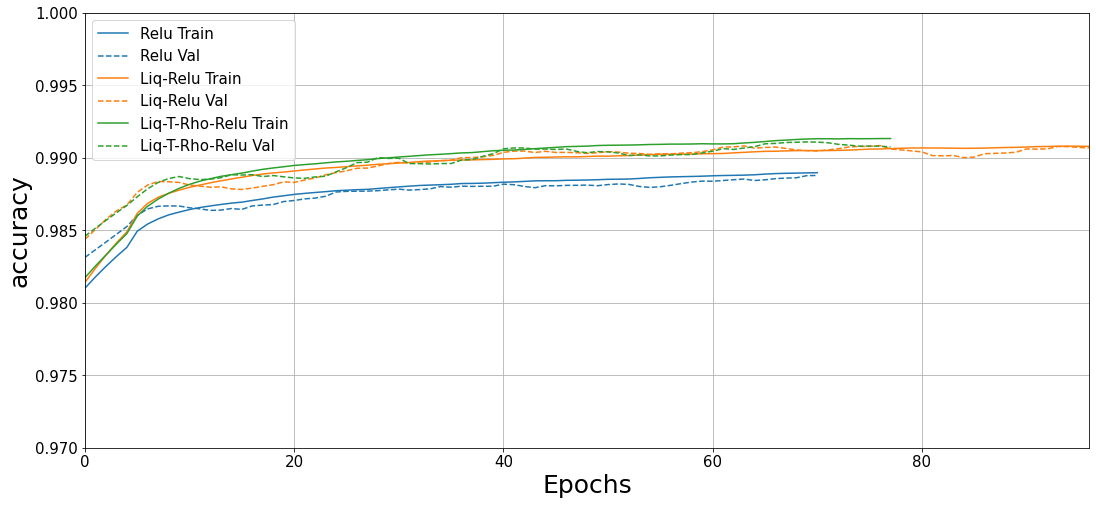

In [49]:
histories['liq-T-rho-ReLU'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)


plotter.plot(histories, metric = "accuracy")
plt.ylim([0.97, 1.0])
plt.ylabel('accuracy')

In [50]:
nsize = 32
model4 = build_model(len(normed_train_data3.keys()),nsize,activ)

early_history4 = model4.fit(normed_train_data3, train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, accuracy:0.9753,  loss:0.0646,  val_accuracy:0.9796,  val_loss:0.0490,  
...............................................................................

Text(0, 0.5, 'accuracy')

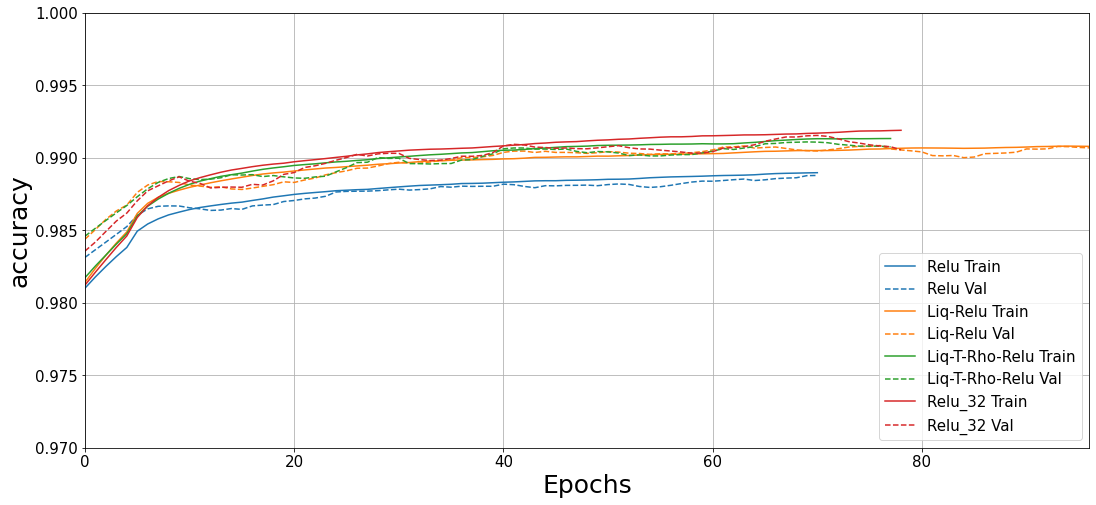

In [51]:
histories['ReLU_32'] = early_history4

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)


plotter.plot(histories, metric = "accuracy")
plt.ylim([0.97, 1.0])
plt.ylabel('accuracy')

In [52]:
loss1, accuracy1 = model1.evaluate(normed_test_data1, test_labels, verbose=2)

print("Testing set for model 1, Accuracy: {:10.5f}".format(accuracy1))

36856/36856 - 1s - loss: 0.0282 - accuracy: 0.9891
Testing set for model 1, Accuracy:    0.98909


In [53]:
loss2, accuracy2 = model2.evaluate(normed_test_data2, test_labels, verbose=2)

print("Testing set for model 2, Accuracy: {:10.5f}".format(accuracy2))

36856/36856 - 1s - loss: 0.0234 - accuracy: 0.9912
Testing set for model 2, Accuracy:    0.99118


In [54]:
loss3, accuracy3 = model3.evaluate(normed_test_data3, test_labels, verbose=2)

print("Testing set for model 3, Accuracy: {:10.5f}".format(accuracy3))

36856/36856 - 1s - loss: 0.0214 - accuracy: 0.9914
Testing set for model 3, Accuracy:    0.99137


In [55]:
loss4, accuracy4 = model4.evaluate(normed_test_data3, test_labels, verbose=2)

print("Testing set for model 4, Accuracy: {:10.5f}".format(accuracy4))

36856/36856 - 1s - loss: 0.0228 - accuracy: 0.9914
Testing set for model 4, Accuracy:    0.99140


In [56]:
scores = [ accuracy1, accuracy2, accuracy3, accuracy4 ]
scores

[0.9890927, 0.9911819, 0.9913718, 0.99139893]

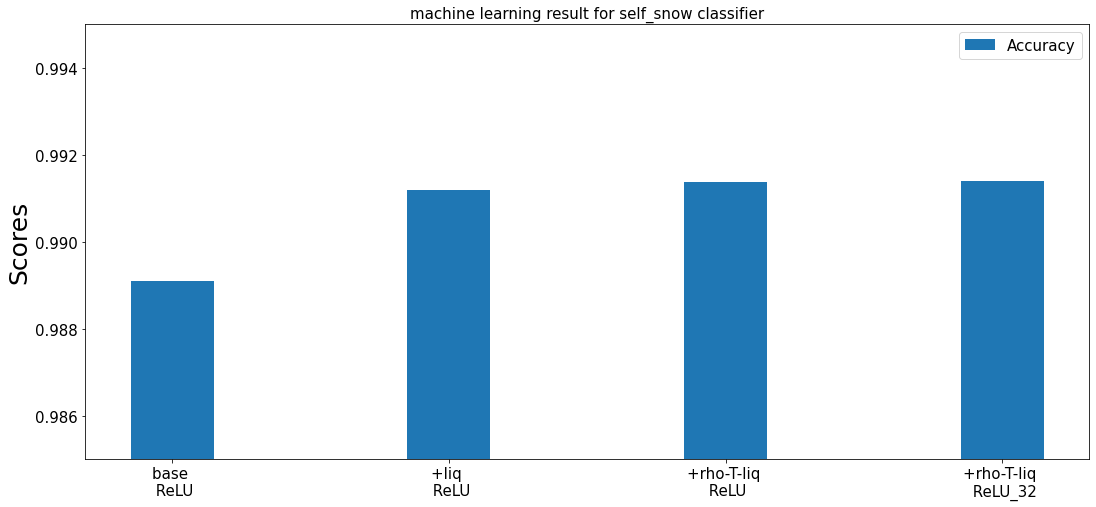

In [60]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

labels = ['base \n ReLU',
 '+liq \n ReLU', '+rho-T-liq \n ReLU', '+rho-T-liq \n ReLU_32' ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, scores, width, label='Accuracy')
#rects2 = ax.bar(x + width/2, mae, width, label='MAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('machine learning result for self_snow classifier')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0.985,0.995)
ax.legend()

#fig.tight_layout()

plt.show()

# Make predictions

Finally, predict the values using data in the testing set:

In [61]:
model1.predict(normed_test_data1)

array([[  6.050856 ,  -7.5045958],
       [  5.847426 ,  -7.005638 ],
       [  5.8617826,  -6.926052 ],
       ...,
       [ 24.045893 , -23.100445 ],
       [  5.1000075,  -4.3047123],
       [ 22.90814  , -22.281206 ]], dtype=float32)

In [62]:
test_dataset2.head()

q_s       n_s       r_s        v_s  liq        cwc         rc
5  -8.001977  8.308913 -9.796159 -14.817060  0.0  -9.247005 -12.155304
8  -7.925193  8.296646 -9.456203 -14.482191  0.0  -9.581404 -12.155304
9  -7.904172  8.292999 -9.378451 -14.406156  0.0  -9.702999 -12.155304
13 -7.838449  8.278251 -9.167760 -14.202600  0.0 -10.251628 -12.155304
16 -7.804390  8.268424 -9.077559 -14.118157  0.0 -10.766237 -12.155304

In [63]:
normed_test_data2.head()

q_s       n_s       r_s       v_s      liq       cwc        rc
5  -1.137727  0.886047 -1.323495 -0.981107 -0.41243  0.352534 -2.309717
8  -1.095915  0.883383 -1.169536 -0.816005 -0.41243  0.192590 -2.309717
9  -1.084468  0.882591 -1.134324 -0.778517 -0.41243  0.134431 -2.309717
13 -1.048679  0.879388 -1.038906 -0.678157 -0.41243 -0.127978 -2.309717
16 -1.030133  0.877254 -0.998056 -0.636524 -0.41243 -0.374116 -2.309717

In [64]:
p2 = pd.DataFrame(model2.predict(normed_test_data2))

In [65]:
p2.head()

0          1
0  4.069603  -7.860899
1  4.052026  -8.224588
2  4.087889  -8.438575
3  4.630866 -10.030735
4  5.379038 -11.809077

# Save models to file

In [66]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model_v2
   

In [67]:
def save2netcdf(model, features_str, labels_str, features_norm, features_ltf, outpath, verbose=True):
    # borrowed from Fabian Jakub, LMU Munich
    # https://github.com/tenstream/tenstream/blob/master/misc/LUT_to_Keras.py

    if model is None:
        D = xr.Dataset()
        D.to_netcdf(outpath)
        return

    layers = [ l for l in model.layers if 'Dropout' not in str(type(l)) ]
    if verbose:
        print("Saving model to "+outpath)
        print("  Features:   "+features_str)
        print("  Labels:     "+labels_str)
        for i,l in enumerate(layers):
            print("  Layer {}: {}, {}, Activation: {}".format(i, str(type(l)), l.weights[0].shape,l.activation.__name__))

    D = xr.Dataset()
    D.attrs['Nlayer'] = np.int32(len(layers))
    D.attrs['features']  = features_str
    D.attrs['labels'] = labels_str
    D.attrs['keras_name'] = model.name

    for i, l in enumerate(layers):
        D["w{}".format(i)] = xr.DataArray(l.weights[0].numpy(), dims=("Ninp_{}".format(i), "Nout_{}".format(i)))
        D["b{}".format(i)] = xr.DataArray(l.weights[1].numpy(), dims=("Nout_{}".format(i)))
        D["w{}".format(i)].attrs['activation'] = l.activation.__name__

        
    # write arrays for normalization of input data to netcdf
    nout = len(layers)-1
    D["inp_logtransform"] = xr.DataArray(features_ltf, dims=("Ninp_0"))
    D["inp_norm_mean"] = xr.DataArray(features_norm['mean'].values, dims=("Ninp_0"))
    D["inp_norm_std"]  = xr.DataArray(features_norm['std'].values, dims=("Ninp_0"))
    
    D.to_netcdf(outpath)

In [68]:
features = 'q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow, cwc, rc'
labels   = 'conv_rimedsnow_cloud_to_graupel'
filename = 'saved_model_v2/conv_rimedsnow_cloud_classifier1_'+version+'.nc'
logtransform = np.array([True, True, True, True, True, True], dtype=bool)
save2netcdf(model1,features,labels,train_stats1,logtransform,filename)

Saving model to saved_model_v2/conv_rimedsnow_cloud_classifier1_10.nc
  Features:   q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow, cwc, rc
  Labels:     conv_rimedsnow_cloud_to_graupel
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (6, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 4: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 2), Activation: linear


In [69]:
features = 'q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow, liqfrac, cwc, rc'
filename = 'saved_model_v2/conv_rimedsnow_cloud_classifier2_'+version+'.nc'
logtransform = np.array([True, True, True, True, False, True, True], dtype=bool)
save2netcdf(model2,features,labels,train_stats2,logtransform,filename)

Saving model to saved_model_v2/conv_rimedsnow_cloud_classifier2_10.nc
  Features:   q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow, liqfrac, cwc, rc
  Labels:     conv_rimedsnow_cloud_to_graupel
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (7, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 4: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 2), Activation: linear


In [70]:
features = 'q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow, liqfrac, cwc, rc, T, rho'
filename = 'saved_model_v2/conv_rimedsnow_cloud_classifier3_'+version+'.nc'
logtransform = np.array([True, True, True, True, False, True, True, False, False], dtype=bool)
save2netcdf(model3,features,labels,train_stats3,logtransform,filename)

Saving model to saved_model_v2/conv_rimedsnow_cloud_classifier3_10.nc
  Features:   q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow, liqfrac, cwc, rc, T, rho
  Labels:     conv_rimedsnow_cloud_to_graupel
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (9, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 4: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 2), Activation: linear


In [71]:
features = 'q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow, liqfrac, cwc, rc, T, rho'
filename = 'saved_model_v2/conv_rimedsnow_cloud_classifier4_'+version+'.nc'
save2netcdf(model4,features,labels,train_stats3,logtransform,filename)

Saving model to saved_model_v2/conv_rimedsnow_cloud_classifier4_10.nc
  Features:   q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow, liqfrac, cwc, rc, T, rho
  Labels:     conv_rimedsnow_cloud_to_graupel
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (9, 32), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (32, 32), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (32, 32), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (32, 32), Activation: relu
  Layer 4: <class 'tensorflow.python.keras.layers.core.Dense'>, (32, 2), Activation: linear
